In [94]:
#Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.api.types import is_numeric_dtype

#suppress display of warnings
import warnings
warnings.filterwarnings('ignore')
# display all dataframe rows
pd.options.display.max_rows = None
# display all dataframe columns
pd.options.display.max_columns = None

# Libraries for recommendation systems
from collections import defaultdict
from surprise import SVD
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

#### 1. Import the necessary libraries and read the provided CSVs as a data frame and perform the below steps.

- Merge the provided CSVs into one data-frame.
- Check a few observations and shape of the data-frame.
- Round off scores to the nearest integers.
- Check for missing values. Impute the missing values if there is any.
- Check for duplicate values and remove them if there is any.
- Keep only 1000000 data samples. Use random state=612.
- Drop irrelevant features. Keep features like Author, Product, and Score.

In [3]:
#Reading all given csv files
DataSet1 = pd.read_csv("Data Set\phone_user_review_file_1.csv")
DataSet2 = pd.read_csv("Data Set\phone_user_review_file_2.csv")
DataSet3 = pd.read_csv("Data Set\phone_user_review_file_3.csv")
DataSet4 = pd.read_csv("Data Set\phone_user_review_file_4.csv")
DataSet5 = pd.read_csv("Data Set\phone_user_review_file_5.csv")

In [4]:
#Shapes of individual dataframes
DataSet1.shape,DataSet2.shape,DataSet3.shape,DataSet4.shape,DataSet5.shape

((374910, 11), (114925, 11), (312961, 11), (98284, 11), (350216, 11))

In [5]:
#Merging all into one dataframe
Main_df = pd.concat([DataSet1,DataSet2,DataSet3,DataSet4,DataSet5])

In [8]:
Main_df .shape

(1251296, 11)

In [9]:
#Verifying the shape of Merged df
DataSet1.shape[0] + DataSet2.shape[0] + DataSet3.shape[0] + DataSet4.shape[0] + DataSet5.shape[0]

1251296

- Merged the dataframe successfully.

In [12]:
Main_df.sample(5)

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
224199,/cellphones/motorola-moto-g3/,9/20/2015,en,in,Amazon,amazon.in,10.0,10.0,"Good product ,no hanging issue,",venkata Krishna,"Motorola Moto G 3rd Generation (Black, 16GB)"
241982,/cellphones/samsung-galaxy-young/,6/27/2014,de,de,Amazon,amazon.de,8.0,10.0,Ein bißchen langsam um neue App zu laufen weng...,Chen Jiang,"Samsung Galaxy Young S6310N Smartphone (8,1 cm..."
44103,/cellphones/apple-iphone-6s/,11/28/2016,nl,nl,Belsimpel,belsimpel.nl,10.0,10.0,"Hij is erg snel en heeft een grote opslag, de ...",Saskia Espenhahn,Apple iPhone 6S 32GB Silver
224639,/cellphones/samsung-s5230/,2/25/2011,ru,ru,Onliner,catalog.onliner.by,6.0,10.0,"Пользуюсь почти год. В принципе, работает норм...",Катерина,Samsung GT-S5230 La Fleur
158004,/cellphones/gionee-elife-e7/,4/2/2015,it,it,Amazon,amazon.it,10.0,10.0,Telefonino di buona fattura con numerosi acces...,saipen,GIONEE ELIFE E7 Smartphone 3GB 32GB 5.5 pollic...


In [7]:
Main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1251296 entries, 0 to 350215
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   phone_url  1251296 non-null  object 
 1   date       1251296 non-null  object 
 2   lang       1251296 non-null  object 
 3   country    1251296 non-null  object 
 4   source     1251296 non-null  object 
 5   domain     1251296 non-null  object 
 6   score      1199479 non-null  float64
 7   score_max  1199479 non-null  float64
 8   extract    1234823 non-null  object 
 9   author     1201151 non-null  object 
 10  product    1251295 non-null  object 
dtypes: float64(2), object(9)
memory usage: 114.6+ MB


- There are missing values in the last 5 columns
- We would just need Author, Product & rating. So we can drop rest of them

In [10]:
#Extracting only relavant features
Truncated_df = Main_df[['author','product','score','score_max']]
#Shape of new df
print('Shape:', Truncated_df.shape)
#Sample data
Truncated_df.sample(5)

Shape: (1251296, 4)


,author,product,score,score_max
106992,Vania A.,"Samsung Galaxy Next Turbo 3.14 pollici, Colore...",4.0,10.0
54149,Дмитрий,Apple iPhone 5s 16GB (серебристый),10.0,10.0
213268,Amazon Kunde,"Wiko 9593 Fever Smartphone (13,2 cm (5,2 Zoll)...",2.0,10.0
214808,Mabru,"Microsoft Nokia Lumia 730 Smartphone (4,7 Zoll...",8.0,10.0
51984,repier88,Apple iPhone 5 16Gb,10.0,10.0


- We seem to have few product names very lengthy & contains description as well

In [10]:
#NULL values
Truncated_df.isnull().sum()

author       50145
product          1
score        51817
score_max    51817
dtype: int64

- We have quite number of null values in our data

In [11]:
#Verifying the proportion of null values in given df
null_count = Truncated_df.isnull().sum()
total = null_count.sort_values(ascending=False)
percent = ( ((null_count / len(Truncated_df.index))*100).round(2) ).sort_values(ascending=False)
  
temp = pd.concat([total, percent], axis=1, keys=['Null count', '% of Null'])
   
temp = temp[ (temp.T != 0).any() ]
temp   

,Null count,% of Null
score,51817,4.14
score_max,51817,4.14
author,50145,4.01
product,1,0.00


- We can impute null values with median/mode in Score/Score_max, but Can't do anything about author & product.
- So lets drop null values w.r.t author & product

In [12]:
#Dropping null values from Author/Product
Truncated_df = Truncated_df.dropna(subset=['author','product'])
Truncated_df.isnull().sum()

author           0
product          0
score        49569
score_max    49569
dtype: int64

- As we see we still have null values in Score & Score_max.
- Since its rating, we can replace null values with Mode. That makes more sense.

In [13]:
#Imputing null values with Mode
Truncated_df['score'].fillna(Truncated_df['score'].mode()[0], inplace = True)
Truncated_df['score_max'].fillna(Truncated_df['score_max'].mode()[0], inplace = True)
Truncated_df.isnull().sum()

author       0
product      0
score        0
score_max    0
dtype: int64

- No null values in data now.

**Round off scores to the nearest integers**

In [12]:
#Sample
Truncated_df['score'].sample(5)

216005     8.0
303259    10.0
260793     6.0
315545    10.0
67536     10.0
Name: score, dtype: float64

In [14]:
Truncated_df['score'] = Truncated_df['score'].round().astype('Int64')
Truncated_df['score_max'] = Truncated_df['score_max'].round().astype('Int64')
#Sample after rounding off
Truncated_df['score'].sample(5)

251129    10
205507    10
20954     10
371868     9
169372     8
Name: score, dtype: Int64

**Duplicate records**

In [15]:
#Dropping duplicate records(rows)
print(Truncated_df.shape)
if Truncated_df.duplicated().any():
    Truncated_df = Truncated_df.drop_duplicates()

print(Truncated_df.shape)

(1201151, 4)
(1067797, 4)


In [29]:
#Duplicate columns
Truncated_df.T.duplicated().any()

False

- We kind of dropped around ~ 1.4 lakh duplicate records

**Choosing random ~10lakh records**

In [16]:
#Choosing random instaed of top/lower records
df = Truncated_df.sample(n = 1000000, random_state = 612)
df.shape

(1000000, 4)

In [16]:
df['score'].value_counts()

10    526898
8     212328
2      90610
6      81159
4      50957
9      27556
7       5374
5       2365
1       1503
3       1232
0         18
Name: score, dtype: Int64

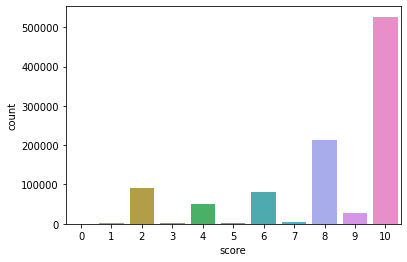

In [40]:
sns.countplot(df['score'])
plt.show()

- High ratings includes 10, 8,2,6,4
- Low scores includes 0,1,3,5,7

In [41]:
df.describe()

,score,score_max
count,1000000.000000,1000000.0
mean,8.142252,10.0
std,2.578582,0.0
min,0.000000,10.0
25%,8.000000,10.0
50%,10.000000,10.0
75%,10.000000,10.0
max,10.000000,10.0


- Mean score is 8 (good score) with 2.5 std
- As seen in countplot, min-0, max-10
- 25%-8, means 75% ratings are 8 or more
- Half(50%) of the ratings are 10
- For all products Max Score seems to be 10

In [42]:
df.skew()

score       -1.33145
score_max    0.00000
dtype: float64

- No skewness in score_max. Its all same for all products
- Score is negatively skewed(Left)

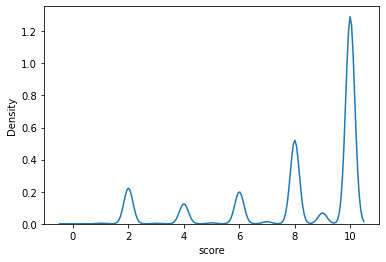

In [47]:
sns.distplot(df['score'],kde=True,hist=False)
plt.show()

**Unique Records**

In [18]:
print('Count of unique values in each column :')
print(df.nunique())

Count of unique values in each column :
author       666168
product       50838
score            11
score_max         1
dtype: int64


- We have 6lacks+ different users who gave ratings
- We have 50k unique products in data
- We have 11 unique scores ranging 0-10
- We have only one (10) uinque max score

In [17]:
df['product'].value_counts(ascending=False).head(15)

OnePlus 3 (Graphite, 64 GB)               2064
Lenovo Vibe K4 Note (White,16GB)          2000
Lenovo Vibe K4 Note (Black, 16GB)         1710
Samsung Galaxy J3 (8GB)                   1697
OnePlus 3 (Soft Gold, 64 GB)              1684
Samsung Galaxy S7 edge 32GB (Verizon)     1623
Samsung Galaxy S7 edge 32GB (T-Mobile)    1560
Nokia 5800 XpressMusic                    1544
Samsung Galaxy S6 zwart / 32 GB           1508
Samsung Galaxy S7 32GB (Verizon)          1443
Nokia 5800                                1419
Samsung Galaxy S7 32GB (T-Mobile)         1357
Nokia N8                                  1346
Samsung Galaxy S5 16GB (Verizon)          1317
LG GX200                                  1309
Name: product, dtype: int64

## `2. Answer the following questions`

- Identify the most rated features.
- Identify the users with most number of reviews.
- Select the data with products having more than 50 ratings and users who have given more than 50 ratings. Report the shape of the final dataset.

In [22]:
#Identify the most rated features.
df.groupby('product')['score'].mean().sort_values(ascending=False).head(25)

product
金屬 + 皮革 = 質感滿分　Wave 723 詳測及心得                                                                                                                                                                               10.0
Sony Xperia U Smartphone (8,9 cm (3,5 Zoll) Touchscreen, Cortex-A9, Dual-Core, 1GHz, 512MB RAM, 5 Megapixel Kamera, Android 2.3) schwarz/weiß                                                               10.0
Desconocido XIAOMI MI4S 4G 64bit Smartphone Snapdragon 808 Hexa Core 5.0 Pulgada LED Sunshine Pantalla FHD Pantalla 3GB+64GB Touch ID 13MP Cámara Doble SIM Tarjeta Smartphone libre desbloqueado Blanco    10.0
Samsung Galaxy S6 Edge G925a 32GB Unlocked GSM 4G LTE Octa-Core Smartphone w/ 16MP Camera - Gold Platinum                                                                                                   10.0
Sony Xperia V LT25I Black ???????�????????                                                                                                                  

In [24]:
# Identify the users with most number of reviews. 
(df['author'].value_counts()).head(25)

Amazon Customer    15079
Cliente Amazon      5950
Client d'Amazon     2534
Amazon Kunde        1824
Anonymous           1202
David                822
Alex                 717
Marco                641
Daniel               623
Александр            592
Andrea               577
Chris                554
Antonio              545
e-bit                513
Michael              508
Дмитрий              504
Сергей               502
Андрей               465
Kindle Customer      460
Roberto              443
Алексей              441
Francesco            434
Alessandro           433
Zákazník             415
Alberto              406
Name: author, dtype: int64

In [25]:
# The product that got most number of reviews.
df['product'].value_counts().head(25)

OnePlus 3 (Graphite, 64 GB)                                                                                                                                                                  2064
Lenovo Vibe K4 Note (White,16GB)                                                                                                                                                             2000
Lenovo Vibe K4 Note (Black, 16GB)                                                                                                                                                            1710
Samsung Galaxy J3 (8GB)                                                                                                                                                                      1697
OnePlus 3 (Soft Gold, 64 GB)                                                                                                                                                                 1684
Samsung Galaxy S7 edge 32GB (V

**Select the data with products having more than 50 ratings and users who have given more than 50 ratings. Report the shape of the final dataset**

In [99]:
#Authors who gave greater than 50 ratings
vc=df['author'].value_counts()
vc[vc > 50][:50]

Amazon Customer    10175
Cliente Amazon      4311
Client d'Amazon     1745
Amazon Kunde        1183
Anonymous            951
David                700
Alex                 618
Marco                568
Daniel               532
Александр            527
Andrea               498
Antonio              485
Сергей               456
Chris                454
Дмитрий              450
Андрей               416
Michael              416
Zákazník             396
e-bit                396
Алексей              396
Francesco            387
Roberto              385
Alessandro           385
Alberto              354
John                 342
Peter                334
Kindle Customer      332
Carlos               325
Mike                 318
unknown              316
Luca                 311
Amazon-Kunde         307
Jose                 295
Fabio                289
Владимир             285
Stefano              284
Евгений              280
Paul                 277
Giuseppe             276
Laura                274


In [41]:
#Creating a dataframe to store the above result
df1 = pd.DataFrame(columns=['author', 'a_50'])
df1['author']=df['author'].value_counts().index.tolist() 
df1['a_50'] = list(df['author'].value_counts() > 50)

In [96]:
# get names of indexes for which count column value is False
index_names = df1[ df1['a_50'] == False ].index 
# drop these row indexes from dataFrame 
df1.drop(index_names, inplace = True) 
df1.head(25)

,author,a_50
0,Amazon Customer,True
1,Cliente Amazon,True
2,Client d'Amazon,True
3,Amazon Kunde,True
4,Anonymous,True
5,David,True
6,Alex,True
7,Marco,True
8,Daniel,True
9,Александр,True


In [98]:
#Product that got greater than 50 ratings
vc=df['product'].value_counts()
vc[vc > 50][:50]

OnePlus 3 (Graphite, 64 GB)                                                                                                                                                                  1889
Samsung Galaxy J3 (8GB)                                                                                                                                                                      1645
Samsung Galaxy S7 edge 32GB (Verizon)                                                                                                                                                        1598
Lenovo Vibe K4 Note (White,16GB)                                                                                                                                                             1585
Samsung Galaxy S7 edge 32GB (T-Mobile)                                                                                                                                                       1548
OnePlus 3 (Soft Gold, 64 GB)  

In [43]:
#Storing the above result into a dataframe
df2 = pd.DataFrame(columns=['product', 'p_50'])
df2['product']=df['product'].value_counts().index.tolist() 
df2['p_50'] = list(df['product'].value_counts() > 50)

In [44]:
# get names of indexes for which count column value is False
index_names = df2[ df2['p_50'] == False ].index 
# drop these row indexes from dataFrame 
df2.drop(index_names, inplace = True)
df2.head(50)

,product,p_50
0,"OnePlus 3 (Graphite, 64 GB)",True
1,"Lenovo Vibe K4 Note (White,16GB)",True
2,"Lenovo Vibe K4 Note (Black, 16GB)",True
3,Samsung Galaxy J3 (8GB),True
4,"OnePlus 3 (Soft Gold, 64 GB)",True
5,Samsung Galaxy S7 edge 32GB (Verizon),True
6,Samsung Galaxy S7 edge 32GB (T-Mobile),True
7,Nokia 5800 XpressMusic,True
8,Samsung Galaxy S6 zwart / 32 GB,True
9,Samsung Galaxy S7 32GB (Verizon),True


In [38]:
# From Main dataframe where product is having more than 50 ratings.  
df3 = df[df['product'].isin(df2['product'])] 
df3.head(25)

,author,product,score,score_max
364302,Bala Konate,BLU VIVO 5R Refresh Smartphone - 5.5-Inch Disp...,10,10
118457,Anand Bhange,"OnePlus 3T (Gunmetal, 6GB RAM + 64GB memory)",10,10
109103,newsflash,Samsung Galaxy S6 zwart / 32 GB,8,10
28587,RAFAEL PRIETO,LG Optimus L5 - Smartphone libre Android (pant...,8,10
49277,Repu,"Apple iPhone 5s 16 Gt ‐puhelin, hopea (lukitse...",8,10
27230,strangery,Nokia X2-00,10,10
221381,william,Samsung S5230 Hello Kitty Pink Unlocked GSM Qu...,10,10
23752,Lakhan Bhagnani,"Lenovo Vibe K5 (Silver, 16GB)",8,10
3937,Marcelo Wygleff,Nokia Smartphone Nokia Lumia 630 Preto Windows...,10,10
77989,Client d'Amazon,Samsung GT-B2710 Téléphone Portable Noir,10,10


In [95]:
#From above df3 where author has given more than 50 ratings.
#Now we get the data with products having more than 50 ratings and users who have given more than 50 ratings
df4 = df3[df3['author'].isin(df1['author'])]
df4.head(25)

,author,product,score,score_max
77989,Client d'Amazon,Samsung GT-B2710 Téléphone Portable Noir,10,10
184036,Domenico,"Huawei P8 lite Smartphone, 5,0 pollici IPS, Du...",10,10
86513,??????????????,Nokia 701,10,10
48102,Rafael,Samsung Galaxy Y,6,10
244867,Amazon Customer,Sony Xperia SP C5302 Unlocked Phone--U.S. Warr...,10,10
38712,Jason,"APPLE iPhone 7 Plus - Gold, 32 GB",1,10
63578,Amazon Kunde,"Samsung S7710 Galaxy Xcover 2 Smartphone (10,2...",10,10
369844,e-bit,Smartphone Samsung Galaxy Gran Prime TV SM-G530,2,10
3801,Daniela,"Smartphone Nokia Lumia 630 Preto Dual Sim, Tv ...",10,10
53658,Cristina,Sony Xperia Tipo - Smartphone libre (pantalla ...,10,10


In [40]:
#Report the shape of the final dataset.
df4.shape

(57817, 4)

### `3. Build a popularity based model and recommend top 5 mobile phones.`

In [46]:
#Recommending the 5 mobile phones based in highest mean score and highest number of ratings the product got. 
def popularity_rec(data):
    ratings_mean_count = pd.DataFrame(data.groupby('product')['score'].mean())
    ratings_mean_count['rating_counts'] = data.groupby('product')['score'].count()
    ratings_mean_count = ratings_mean_count.sort_values(by=['score','rating_counts'], ascending=[False,False])
    print('Top 5 recommendations for the products are: \n')
    display(ratings_mean_count.head())
    return

**Using the most frequent products/authors**

In [48]:
popularity_rec(df4)

Top 5 recommendations for the products are: 



,score,rating_counts
product,,
ASUS ZenFone 3 Max ZC520TL 16GB (серый),10.0,35
ASUS ZenFone 3 Max ZC520TL 16GB (серебристый),10.0,34
ASUS ZenFone 3 Max ZC520TL 16GB (золотистый),10.0,32
Samsung Galaxy Note5,10.0,27
Nokia E51 Cep Telefonu,10.0,24


#### Using the original dataframe

In [50]:
#Passing whole dataframe
popularity_rec(df)

Top 5 recommendations for the products are: 



,score,rating_counts
product,,
SAMSUNG Player Star 2,10.0,576
SAMSUNG Galaxy S,10.0,380
NOKIA E71 Noir,10.0,318
Apple iPhone 4 16Go Noir,10.0,242
SAMSUNG Galaxy Ace,10.0,225


- Using original dataframe seems to be best for popularity based model
- We can see the rating_counts as high compared to most frequest products among most frequent buyers

### `4. Build a collaborative filtering model using SVD.`

You can use SVD from surprise or build it from scratch(Note: Incase you’re building it from scratch you
can limit your data points to 5000 samples if you face memory issues). Build a collaborative filtering model using kNNWithMeans from surprise. You
can try both user-based and item-based model.

In [51]:
df.columns

Index(['author', 'product', 'score', 'score_max'], dtype='object')

In [53]:
#Eliminating score_max here
cols = ['author','product','score']
df = df.reindex(columns=cols)
df.head()

,author,product,score
364302,Bala Konate,BLU VIVO 5R Refresh Smartphone - 5.5-Inch Disp...,10
118457,Anand Bhange,"OnePlus 3T (Gunmetal, 6GB RAM + 64GB memory)",10
109103,newsflash,Samsung Galaxy S6 zwart / 32 GB,8
240242,Mohammed D Abbas,"Lenovo Ideaphone S920 (White, 4GB)",8
17002,matt,Doogee Nouveau 5.0'' DOOGEE NOVA Y100x IPS OGS...,10


In [54]:
# Keep only 5000 data samples. Use random state=612
df_data = df.sample(n=5000, random_state=612)

In [56]:
#Build a collaborative filtering model using SVD. 
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df_data,reader = reader)
data

In [58]:
#building the training set
train = data.build_full_trainset()

In [66]:
#Displaying the trainset
train.ur

defaultdict(list,
            {0: [(0, 10.0)],
             1: [(1, 10.0)],
             2: [(2, 2.0)],
             3: [(3, 10.0)],
             4: [(4, 10.0)],
             5: [(5, 10.0)],
             6: [(6, 10.0)],
             7: [(7, 4.0)],
             8: [(8, 10.0)],
             9: [(9, 8.0)],
             10: [(10, 2.0)],
             11: [(11, 10.0)],
             12: [(12, 4.0)],
             13: [(13, 6.0)],
             14: [(14, 8.0)],
             15: [(15, 10.0)],
             16: [(16, 2.0)],
             17: [(17, 4.0)],
             18: [(18, 10.0)],
             19: [(19, 2.0)],
             20: [(20, 9.0), (1090, 10.0)],
             21: [(21, 1.0)],
             22: [(22, 4.0)],
             23: [(23, 10.0)],
             24: [(24, 10.0)],
             25: [(25, 8.0)],
             26: [(26, 10.0)],
             27: [(27, 10.0)],
             28: [(28, 10.0)],
             29: [(29, 8.0)],
             30: [(30, 8.0)],
             31: [(31, 10.0)],
            

In [60]:
#SVD model
algo = SVD()
algo.fit(train)

In [62]:
#Predicting ratings for all pairs that are NOT in the training set.
test = train.build_anti_testset()
predictions = algo.test(test)

In [64]:
#Printing 10 sample predictions
predictions[:10]

[Prediction(uid='Arul Amuthan C', iid='Samsung Galaxy S7 Smartphone (12,92 cm (5,1 Zoll) Touch-Display, 32GB interner Speicher, Android OS) pink', r_ui=8.1512, est=8.481722285446098, details={'was_impossible': False}),
 Prediction(uid='Arul Amuthan C', iid='Apple iPhone 5, Black 16GB (Unlocked)', r_ui=8.1512, est=7.855181648544644, details={'was_impossible': False}),
 Prediction(uid='Arul Amuthan C', iid='Sony Phones XPERIA S UK Sim Free Mobile Phone', r_ui=8.1512, est=8.266999899084112, details={'was_impossible': False}),
 Prediction(uid='Arul Amuthan C', iid='Samsung Galaxy S6 edge+ 32GB (T-Mobile)', r_ui=8.1512, est=8.636429507299093, details={'was_impossible': False}),
 Prediction(uid='Arul Amuthan C', iid='Galaxy Samsung Galaxy Note 4 SM-N910T 4G LTE - 32GB - Charcoal Black (T-Mobile)', r_ui=8.1512, est=8.532843279099415, details={'was_impossible': False}),
 Prediction(uid='Arul Amuthan C', iid='Sony Smartphone Dual Chip Sony Xperia E1 Desbloqueado Preto Android 4.3 3G Câmera 3 MP

**Top 5 Products**

In [67]:
def get_top_n(predictions, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [68]:
# Try and recommend top 5 products for test users
top_n = get_top_n(predictions, n=5)

In [69]:
#Top 5 recommendations for each Test user
top_n

defaultdict(list,
            {'Arul Amuthan C': [('OnePlus 3 (Graphite, 64 GB)',
               9.349175042262255),
              ('Samsung Galaxy S7 edge 32GB (T-Mobile)', 9.129777311661929),
              ('LG D802 G2 Smartphone, 16 GB, Nero [Italia]',
               9.104226848743377),
              ('Samsung Galaxy S7 edge 32GB (AT&T)', 9.04635562402983),
              ('Samsung Galaxy S4 16GB (Verizon)', 9.032056872446795)],
             'Ein Amazon-Kunde': [('OnePlus 3 (Graphite, 64 GB)',
               9.240841325844764),
              ('Samsung Galaxy J3 (8GB)', 9.133145013975557),
              ('Samsung Galaxy S7 edge 32GB (T-Mobile)', 9.108655994419324),
              ('Samsung Galaxy S4 16GB (Verizon)', 9.043079934274502),
              ('Samsung Galaxy S5 Smartphone (5,1 Zoll (12,9 cm) Touch-Display, 16 GB Speicher, Android 4.4) electric blue',
               9.023632974150736)],
             'Samson Mwangi': [('Samsung Galaxy S7 edge 32GB (T-Mobile)',
               8.76

**Evaluate the collaborative model. Print RMSE value**

In [70]:
#Evaluate the collaborative model. Print RMSE value.
print("SVD Model : Test Set")
accuracy.rmse(predictions, verbose=True)

SVD Model : Test Set
RMSE: 0.3473


0.3472936656458508

**Cross validation techniques on SVD Model**

In [71]:
cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.6588  2.5774  2.6898  2.5123  2.4860  2.5848  0.0795  
Fit time          0.44    0.52    0.58    0.61    0.61    0.55    0.06    
Test time         0.00    0.02    0.01    0.01    0.01    0.01    0.01    


{'test_rmse': array([2.65882149, 2.57737976, 2.68978049, 2.51225471, 2.48600266]),
 'fit_time': (0.44331789016723633,
  0.5173981189727783,
  0.5804967880249023,
  0.6131248474121094,
  0.6054275035858154),
 'test_time': (0.0020487308502197266,
  0.0181577205657959,
  0.012208223342895508,
  0.012450456619262695,
  0.010343313217163086)}

### `Item based model using kNNWithMeans from surprise`

In [73]:
# Read dataset.
reader = Reader(rating_scale=(1, 10))
data_item = Dataset.load_from_df(df_data,reader = reader)

In [77]:
traini, testi = train_test_split(data_item, test_size=.15)

In [75]:
#item-based collaborative filtering
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(traini)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [78]:
# run the  model against the testset
testi_pred = algo.test(testi)
testi_pred[:10]

[Prediction(uid='JDubbs413 ', iid='Samsung Galaxy S6 32GB (T-Mobile)', r_ui=10.0, est=10, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='Lauraa', iid='Apple iPhone 5C Smartphone débloqué 4 pouces 16 Go iOS 7 Bleu (import Europe)', r_ui=2.0, est=2.0, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='HolaB', iid='Huawei Honor 4X Smartphone (svart) Telenor', r_ui=10.0, est=10, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='Em', iid='Samsung Galaxy J5 2016 Sim Free Mobile Phone - White', r_ui=10.0, est=10, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='Mahesh', iid='Samsung Galaxy S3 i9300i Unlocked 16GB (Marble White)', r_ui=10.0, est=10, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='michael', iid='Sony Xperia Z3+ Smartphone (5,2 Zoll (13,2 cm) Touch-Display, 32 GB Speicher, Android 5.0) kupfer', r_ui=10.0, est=10, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='Clebe

In [79]:
# RMSE
print("Item-based Model : Test Set")
accuracy.rmse(testi_pred, verbose=True)

Item-based Model : Test Set
RMSE: 0.8912


0.8912031881065897

### `User based model using kNNWithMeans from surprise`

In [81]:
reader = Reader(rating_scale=(1, 10))
data_user = Dataset.load_from_df(df_data,reader = reader)

In [82]:
trainu, testu = train_test_split(data_user, test_size=.15)

In [83]:
# User-based collaborative filtering
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainu)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [46]:
# we can now query for specific predicions
uid = 'Frances DeSimone'  # raw user id
iid = 'Samsung Galaxy Star Pro DUOS S7262 Unlocked Ce.'  # raw item id

In [47]:
# get a prediction for specific users and items.
pred = algo.predict(uid, iid, verbose=True)

user: Frances DeSimone item: Samsung Galaxy Star Pro DUOS S7262 Unlocked Ce. r_ui = None   est = 8.17   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


In [85]:
# run the trained model against the testset
testu_pred = algo.test(testu)
testu_pred[:10]

[Prediction(uid='lovesamsung9985 ', iid='Samsung Galaxy S4 Active 16GB (AT&T)', r_ui=9.0, est=8.160235294117648, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='Angel', iid='Motorola SPICE XT300', r_ui=8.0, est=8.160235294117648, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='D.L.', iid='HTC Wildfire S Smartphone (8.1 cm (3.2 Zoll) Touchscreen, WiFi (b/g/n), Android OS 2.3.3) schwarz', r_ui=10.0, est=8.160235294117648, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='Jill Page', iid='Nokia 105 SIM-Free Mobile Phone, Black', r_ui=10.0, est=8.160235294117648, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='lightfoot44', iid='Samsung S390G', r_ui=6.0, est=8.160235294117648, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='Alexter10', iid='Samsung Galaxy Note 3 64G

In [86]:
# RMSE value for User Based CF
print("User-based Model : Test Set")
accuracy.rmse(testu_pred, verbose=True)

User-based Model : Test Set
RMSE: 2.6051


2.6051308232766854

**cross validation on whole dataset**

In [92]:
#Try cross validation techniques to get better results.
cross_validate(algo,data_user, measures=['RMSE'], cv=5, verbose=False)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([2.57377503, 2.59817532, 2.60687069, 2.58372257, 2.69453933]),
 'fit_time': (0.3447694778442383,
  0.370258092880249,
  0.3750734329223633,
  0.35396599769592285,
  0.3660106658935547),
 'test_time': (0.0060193538665771484,
  0.004986763000488281,
  0.005984783172607422,
  0.005982637405395508,
  0.00598597526550293)}

In [93]:
#Try cross validation techniques to get better results.
cross_validate(algo,data_item, measures=['RMSE'], cv=5, verbose=False)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([2.55613453, 2.61729657, 2.69136196, 2.49485531, 2.68599925]),
 'fit_time': (0.3793349266052246,
  0.3667182922363281,
  0.3551638126373291,
  0.35729074478149414,
  0.3616306781768799),
 'test_time': (0.0,
  0.004986763000488281,
  0.005993366241455078,
  0.005983829498291016,
  0.006987810134887695)}

**Report your findings and inferences.**

Ans:

    Data:
    - Data is too large & could take lot of time to reproduce.
    - This data can be used for high level recommendations such as hybrid, geographic based, weightage based recommendations
    - Data has quite no.of null values but overall % is less, so dropping wouldn't be a problem
    - It has different languages & would require translators to properly use in models. Without that,Models would be biased.
    - Good no.of anonymous users given ratings.
    
    Results:
    - Samsung GT, Huawai, Nokia phones are best with ratings & frequently bought too.
    - Samsung Galaxy Y, Iphone 7plus, Galaxy Prime are few among frequently brought but with lower ratings.
    - Asus, Samsung products are highly popular
    - SVD model has lower RMSE compared to Item-based, user-based.
        

**Question :In what business scenario you should use popularity based Recommendation Systems ?**

Ans:
    - Popularity based is userful for cold-start problems.
    - when we have no prior info on item/user history, we will use popularity techniques.
    - when ML model is unabled to predict (was_impossible: True), we can use popularity in that place.
    - KNN model unable to find any neighbours (Gray Sheep Problem)
    - Popularity based recommendation is as important as other methods, in order to make new users/less active users to keep           coming back to using the product.
    
    Examples include:
    - To recommend Trending content within product/users like in Amazon/Netflix/Prime.
    - Most frequent viewed items for any specific season sales, can be recommended using popularity based techniques.
    - Zomoto/Swiggy uses to recommend top-buy foods in that locality when user is new to that location.
    - News includes latest top stories.
    - Instagram Reels/Tiktok video apps recommend top-most trending videos to new users/less active users.
    - Twitter recommnds popular accounts to follow for a new users. 
    


**Question: In what business scenario you should use CF based Recommendation Systems ?**

Ans:
    User preference is highly mattered in business. Not all users have same preference. As an user, once we are familier with the service/product, we don't like to recieve similar recommendations again & again. So we would need something based out of product/user activity/history. Recommending the most popular English movie in China doesn't make much sense, because few people understand that language. So we would need to recommend something very specific to a users belongs to certain age group of gender of particular location. 
    
    Example includes:
    - Amazon recommnds cricket ball as I previously bought Cricket bat.
    - Netflix suggest new Matt Damon movie as I previously liked The Martian & suggest Interstaller based on the same.
    - Twitter showing the tweets likes by my friends (Because of similarity among my friends/followers)
    - Zomoto suggests best pizza in new location as mostly I order pizza at my hometown.
    - Tiktok shows all regional videos in my feed as mostly like my native language content
    - Google news suggests local news based out of my location
    - Fav songs of my fav stars that I follow.

**Question: What other possible methods can you think of which can further improve the recommendation for different users ?**

Ans:
    - Recommendations are very powerful way to engage the user with the product/service. So mixing the methods such as                 Collaborative & Popularity would be helpful.
    - We would need to use Hybrid based technigues
    - Knowing each user is important, so keep an weightage for every session of user & record the preferences. 
    - Make sure mixed recommendations be available to user
    - Use Latent Factor models for high level recommendation and then improving them using content based systems by using               information on users or items
    - Mising both item-item & user-user would yield better results
    - Improve the accuracy as much as possible
    - Netflix uses option like 'is this npt useful?' give weightage to such feedback from user end.
    - Apart from Popularity and Collaborative Filtering , Content-based, Demographic, Utility based, Knowledge based                     recommendations can be used as per the user needs.
    

In [ ]:
################# THE END ####################